<img src="data/photutils_banner.svg" width=500 alt="Photutils logo">

# Photutils

- Code: https://github.com/astropy/photutils
- Documentation: http://photutils.readthedocs.org/en/stable/
- Issue Tracker:  https://github.com/astropy/photutils/issues

## Photutils capabilities:

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - Image segmentation
  - local peak finder
- Aperture photometry
- PSF photometry
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis


## In this additional notebook, we will review:

- Aperture photometry (repeat of photutils overview material)
- Using image segmentation to generate elliptical apertures of extended sources

## Preliminaries

In [1]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'viridis'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading data and error arrays from FITS files.  These are cutouts from the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [2]:
from astropy.io import fits
sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

sci_hdulist[0].header['BUNIT'] = 'electron/s'

Print some info about the data.

In [3]:
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


Define the data and error arrays.

In [4]:
data = sci_hdulist[0].data.astype(np.float)
error = rms_hdulist[0].data.astype(np.float)

Extract the data header and create a WCS object.

In [5]:
from astropy.wcs import WCS

hdr = sci_hdulist[0].header
wcs = WCS(hdr)

Display the data.

In [6]:
from astropy.visualization import ImageNormalize, LogStretch

Text(0.5,1,'XDF F160W Cutout')

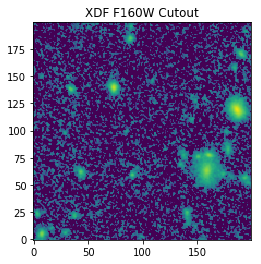

In [7]:
norm = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
plt.imshow(data, norm=norm)
plt.imshow(data, norm=norm)
plt.title('XDF F160W Cutout')

---
# Part 1:  Aperture Photometry

## Performing aperture photometry at multiple positions

In [8]:
import astropy.units as u
from photutils.utils import calc_total_error
from photutils import CircularAperture, aperture_photometry

positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

unit = u.electron / u.s

phot = aperture_photometry(data, apertures, error=tot_error, unit=unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int32,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


## Bad pixel masking

In [9]:
# create a bad pixel
data2 = data.copy()
y, x = 59, 91
data2[y, x] = 100.

aperture_photometry(data2, apertures, error=tot_error)

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int32,float64,float64,float64,float64
1,90.73,59.43,100.11319073802662,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


Note the large `aperture_sum` in the first source due to the bad pixel.  Now mask the bad pixel so that it does not contribute to the photometry.

In [10]:
mask = np.zeros_like(data2, dtype=bool)
mask[y, x] = True

aperture_photometry(data2, apertures, error=tot_error, mask=mask)

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int32,float64,float64,float64,float64
1,90.73,59.43,0.11319073802661661,0.007991749523793938
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


## Performing aperture photometry at multiple positions using multiple apertures

First define three different aperture shapes (different radii), but with the same positions.

In [11]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radii = [5., 7.5, 9., 11.]
apertures = [CircularAperture(positions, r=r) for r in radii]

In [12]:
phot = aperture_photometry(data, apertures, error=tot_error, unit=unit)
phot

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3
,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,0.1393681049395568,0.01204875328039566,0.1567233443389367,0.01445528321856259,0.1849595602145676,0.017658184899138073
2,73.63,139.41,0.6150243632978061,0.00816628074162013,0.7335947208192003,0.012172550968591505,0.7584450135659184,0.014587065263802693,0.7850145516886573,0.017807733526686798
3,43.62,61.63,0.21352615994892402,0.008069761430877863,0.26397917122319403,0.012092275127651105,0.27379087888794956,0.014495639780282177,0.2740932474086888,0.01770451932437249


The output table above now contains columns for the `aperture_sum` and `aperture_sum_err` for each aperture.  The column names are appended with `_N`, where N is running index of the apertures in the input `apertures` list, i.e. the first aperture is `_0`, the second is `_1`, etc.

We can add columns to the table indicating the aperture radii.

In [13]:
phot['aperture_radius_0'] = np.ones(len(phot)) * radii[0] * u.pix
phot['aperture_radius_1'] = np.ones(len(phot)) * radii[1] * u.pix
phot['aperture_radius_2'] = np.ones(len(phot)) * radii[2] * u.pix
phot['aperture_radius_3'] = np.ones(len(phot)) * radii[3] * u.pix
phot

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_radius_0,aperture_radius_1,aperture_radius_2,aperture_radius_3
,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,pix,pix,pix,pix
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,0.1393681049395568,0.01204875328039566,0.1567233443389367,0.01445528321856259,0.1849595602145676,0.017658184899138073,5.0,7.5,9.0,11.0
2,73.63,139.41,0.6150243632978061,0.00816628074162013,0.7335947208192003,0.012172550968591505,0.7584450135659184,0.014587065263802693,0.7850145516886573,0.017807733526686798,5.0,7.5,9.0,11.0
3,43.62,61.63,0.21352615994892402,0.008069761430877863,0.26397917122319403,0.012092275127651105,0.27379087888794956,0.014495639780282177,0.2740932474086888,0.01770451932437249,5.0,7.5,9.0,11.0


or put them in the table metadata.

In [14]:
for i in range(len(radii)):
    phot.meta['aperture_{}'.format(i)] = 'Circular aperture with r={} pix'.format(radii[i])

In [15]:
phot.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.1.1, photutils: 0.6'),
             ('aperture_photometry_args', "method='exact', subpixels=5"),
             ('aperture_0', 'Circular aperture with r=5.0 pix'),
             ('aperture_1', 'Circular aperture with r=7.5 pix'),
             ('aperture_2', 'Circular aperture with r=9.0 pix'),
             ('aperture_3', 'Circular aperture with r=11.0 pix')])

## Aperture photometry using Sky apertures

First, let's define the sky coordinates by converting our pixel coordinates.

In [16]:
from astropy.wcs.utils import pixel_to_skycoord

positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
x, y = np.transpose(positions)
coord = pixel_to_skycoord(x, y, wcs)
coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

Now define a circular aperture in sky coordinates.

For sky apertures in angular units, the aperture radius must be a `Quantity`, in either pixel or angular units.

In [17]:
from photutils import SkyCircularAperture

radius = 5. * u.pix
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 5. pix>

In [18]:
radius = 0.5 * u.arcsec
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 0.5 arcsec>

When using a sky aperture, `aperture_photometry` needs the WCS transformation.

In [19]:
# via the wcs keyword
phot = aperture_photometry(data, sky_apers, wcs=wcs)
phot

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,"deg,deg",
int32,float64,float64,object,float64
1,90.72999999978606,59.43000000028451,"53.158891500867604,-27.765002141410175",0.14686106763484336
2,73.63000000046281,139.4099999994196,"53.15921313626186,-27.763669058236427",0.7507009236812127
3,43.619999999931224,61.63000000007014,"53.159778816470286,-27.764965241221894",0.269514657597839


In [20]:
# or via a FITS hdu (i.e. header and data)
phot = aperture_photometry(sci_hdulist[0], sky_apers)
phot

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,"deg,deg",electron / s
int32,float64,float64,object,float64
1,90.72999999978606,59.43000000028451,"53.158891500867604,-27.765002141410175",0.14686106763484336
2,73.63000000046281,139.4099999994196,"53.15921313626186,-27.763669058236427",0.7507009236812127
3,43.619999999931224,61.63000000007014,"53.159778816470286,-27.764965241221894",0.269514657597839


## Encircled flux

Here we want to perform aperture photometry at a single position with *many* apertures.

Instead of generating a big table, we'll simply loop over the apertures and extract the fluxes from individual tables.

In [21]:
radii = np.linspace(0.1, 20, 100)   # 100 apertures
flux = []
for r in radii:
    ap = CircularAperture(positions[1], r=r)  # single position
    phot = aperture_photometry(data, ap)
    flux.append(phot['aperture_sum'][0])

Text(0,0.5,'Aperture Sum ($e^{-1}/s$)')

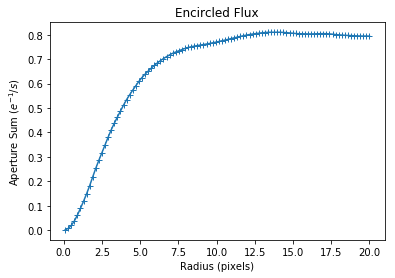

In [22]:
plt.plot(radii, flux, '+-')
plt.title('Encircled Flux')
plt.xlabel('Radius (pixels)')
plt.ylabel('Aperture Sum ($e^{-1}/s$)')

## More about apertures:  Advanced usage

### Aperture masks

In [23]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

Create a list of `ApertureMask` objects using the `to_mask()` method.

In [24]:
masks = apertures.to_mask(method='exact')

Let's plot the first one.

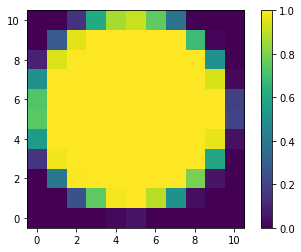

In [25]:
mask = masks[0]   # the first one
plt.imshow(mask)
plt.colorbar()

The above image is a cutout of the aperture mask.

We can create an image with the aperture mask at its position.

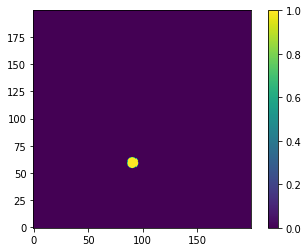

In [26]:
img = mask.to_image(shape=((200, 200)))
plt.imshow(img)
plt.colorbar()

We can also create a cutout from a data image over the mask domain.

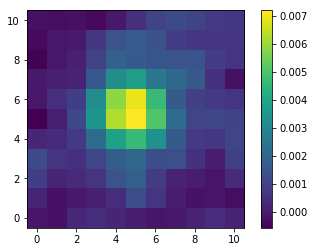

In [27]:
data_cutout = mask.cutout(data)
plt.imshow(data_cutout)
plt.colorbar()

We can also create a mask-weighted cutout from the data.  Here the circular aperture mask has been applied to the data.

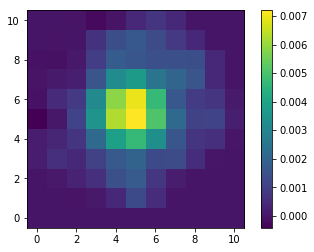

In [28]:
data_cutout_aper = mask.multiply(data)
plt.imshow(data_cutout_aper)
plt.colorbar()

---
# Part 2:  Image Segmentation (extended version)

Image segmentation is the process where sources are identified and labeled in an image.

The sources are detected by using a S/N threshold level and defining the minimum number of pixels required within a source.

First, let's define a threshold image at 2$\sigma$ (per pixel) above the background.

In [29]:
bkg = 0.  # background level in this image
nsigma = 2.
threshold = bkg + (nsigma * error)  # this should be background-only error

Now let's detect "8-connected" sources of minimum size 5 pixels where each pixel is 2$\sigma$ above the background.

"8-connected" pixels touch along their edges or corners. "4-connected" pixels touch along their edges. For reference, SExtractor uses "8-connected" pixels.

The result is a segmentation image (`SegmentationImage` object).  The segmentation image is the isophotal footprint of each source above the threshold.

In [30]:
from photutils import detect_sources

npixels = 5
segm = detect_sources(data, threshold, npixels)

print('Found {0} sources'.format(segm.nlabels))

Found 22 sources


Display the segmentation image.

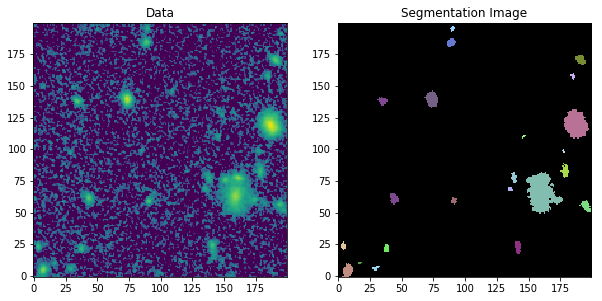

In [31]:
from photutils.utils import random_cmap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(data, norm=norm)
lbl1 = ax1.set_title('Data')
ax2.imshow(segm, cmap=segm.cmap())
lbl2 = ax2.set_title('Segmentation Image')

It is better to filter (smooth) the data prior to source detection.

Let's use a 5x5 Gaussian kernel with a FWHM of 2 pixels.

In [32]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

sigma = 2.0 * gaussian_fwhm_to_sigma    # FWHM = 2 pixels
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

ssegm = detect_sources(data, threshold, npixels, filter_kernel=kernel)

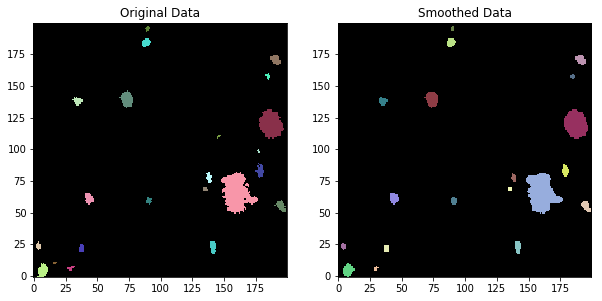

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(segm, cmap=segm.cmap())
lbl1 = ax1.set_title('Original Data')
ax2.imshow(ssegm, cmap=ssegm.cmap())
lbl2 = ax2.set_title('Smoothed Data')

### Source deblending

Note above that some of our detected sources were blended.  We can deblend them using the `deblend_sources()` function, which uses a combination of multi-thresholding and watershed segmentation.

C:\Users\pj\Anaconda3\lib\site-packages\skimage\util\arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
        Use max_label instead. [astropy.utils.decorators]


Found 22 sources


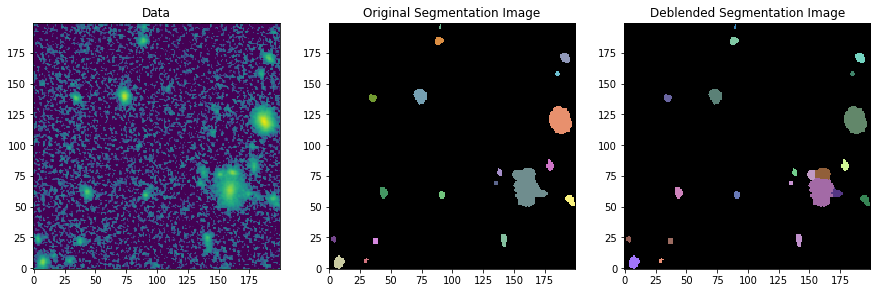

In [34]:
from photutils import deblend_sources

segm2 = deblend_sources(data, ssegm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(ssegm, cmap=ssegm.cmap())
ax2.set_title('Original Segmentation Image')
ax3.imshow(segm2, cmap=segm2.cmap())
ax3.set_title('Deblended Segmentation Image')

print('Found {0} sources'.format(segm2.max))

## Measure the photometry and morphological properties of detected sources

In [35]:
from photutils import source_properties
catalog = source_properties(data, segm2, error=error, wcs=wcs)

`catalog` is a `SourceCatalog` object.  It behaves like a list of `SourceProperties` objects, one for each source.

In [36]:
catalog

In [37]:
catalog[0]   # the first source

In [38]:
catalog[0].xcentroid    # the xcentroid of the first source

<Quantity 7.5533147 pix>

Please go [here](http://photutils.readthedocs.org/en/latest/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties) to see the complete list of available source properties.

We can create a Table of isophotal photometry and morphological properties using the ``to_table()`` method of `SourceCatalog`:

In [39]:
tbl = catalog.to_table()
tbl

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int32,float64,float64,object,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.553314695516333,5.010501829306161,"53.160458468242005,-27.765908716240137","53.160454917138026,-27.765905807856235",0.3140969689702615,0.007382149242648998,None,None,None,4.0,12.0,0.0,10.0,0.0016270348569378257,0.013324600644409657,11.0,8.0,7.0,5.0,67.0,4.61809077155419,28.97056274847714,2.152277789049281,1.663725301759035,0.6343977723822978,1.28058873137882,0.2269932300449249,1.293649730982456,2.920636841723351,0.511169077448774,4.479644719224701,0.3493684482403228,-0.07973237101161172,0.2277810909618303
2,29.243742267394136,6.223130228476329,"53.160049913524965,-27.76588861601516","53.160046362429526,-27.765885707669323",0.030047482228837907,0.00299605931730985,None,None,None,28.0,31.0,5.0,8.0,0.0018685600953176618,0.004033097997307777,30.0,8.0,29.0,6.0,11.0,1.8712051592547776,10.65685424949238,1.0000337677496938,0.7705009609590648,0.6374702824816553,0.7673272371535811,0.22952505624598118,1.2979007404545255,0.8042119836574845,0.2030652053917651,0.7895272838210062,1.329815661403967,-0.6840530934138133,1.3545493776741093
3,140.89475249322624,23.45912655899891,"53.15794682989969,-27.765601898029036","53.157943278826345,-27.765598989879106",0.13003053539432585,0.005716234401462344,None,None,None,139.0,143.0,18.0,27.0,0.0016787038184702396,0.006731071043759584,139.0,22.0,141.0,25.0,40.0,3.5682482323055424,23.656854249492376,2.4162760408631145,1.13484508744997,0.8828436563098752,-1.5004886294103097,0.5303330131748549,2.129168172452997,1.3103303203737575,-0.3188830475794376,5.8159329577847005,0.7734872022469176,0.0848193946204427,0.17426674978579154
4,37.57504995503402,21.962293185971536,"53.15989290043491,-27.765626338833183","53.15988934931247,-27.765623430501968",0.06266678764950484,0.004048464129814733,None,None,None,36.0,39.0,20.0,24.0,0.001770949806086719,0.004707001149654388,36.0,24.0,38.0,21.0,20.0,2.5231325220201604,14.0,1.3116421627846628,1.0261975514953874,0.622806191969407,-1.5649545140475811,0.21762384542691615,1.2781575641778935,1.0531041880442673,-0.0038982916884051726,1.7203823898452888,0.9495816266858995,0.004303399272884629,0.5812709975732416
5,3.643284534370782,23.72824167960622,"53.16053200676377,-27.76559673412496","53.16052845562072,-27.765593825734214",0.05923816212452948,0.003834152958767743,None,None,None,2.0,5.0,21.0,26.0,0.0018495642580091953,0.005274028051644564,5.0,25.0,4.0,24.0,18.0,2.393653682408596,13.071067811865476,1.3343681210986853,0.8882926571738362,0.7462169386202122,-1.3176082274680707,0.3342971529907067,1.502171733968925,0.8512749837765318,-0.2404382004579082,1.7183271436168586,1.2230448704589203,0.34227092183790486,0.6059076155116804
6,194.74036574633462,55.57240669416572,"53.15693246096231,-27.765066930160202","53.15692890985242,-27.765064022104763",0.14216194639448076,0.006159360692846708,None,None,None,191.0,198.0,51.0,59.0,0.001774212229065597,0.006075085140764713,191.0,56.0,194.0,57.0,46.0,3.826519928662906,24.72792206135785,2.447451650653097,1.3918124788738224,0.822560069451999,-1.0110407075015062,0.4313217674790756,1.7584636492363106,3.079805569833908,-1.8235667252056647,4.847355988799556,0.4177488097488158,0.3143127225285014,0.2654199761743742
7,43.62239333293608,61.473548833019414,"53.15977

A subset of source can be specified, defined by the their labels in the segmentation image.

In [40]:
labels = [1, 5, 7, 12]
cat2 = source_properties(data, segm, error=error, wcs=wcs, labels=labels)
tbl2 = cat2.to_table()
tbl2

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int32,float64,float64,object,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.417527874713313,4.8493788790067835,"53.16046102677219,-27.76591140092693","53.160457475668466,-27.765908492542792",0.31498816539533436,0.007377560313203548,None,None,None,3.0,11.0,0.0,10.0,0.0018419958651065826,0.013324600644409657,6.0,10.0,7.0,5.0,67.0,4.61809077155419,30.76345596729059,2.2879845999035453,1.6047813488347935,0.7127726247725202,1.2479863837925609,0.29860482937584176,1.4257298052253753,2.842971097748126,0.8001173108390018,4.96722560921568,0.3684477896859481,-0.11869863696996193,0.21087957333021717
5,37.61205009409473,22.088896345844184,"53.15989220280341,-27.765624228968182","53.15988865168074,-27.76562132063703",0.06478380726184696,0.004148875775069471,None,None,None,36.0,39.0,20.0,25.0,0.0018309974111616611,0.004707001149654388,36.0,20.0,38.0,21.0,21.0,2.5854414729132054,14.828427124746192,1.4462751795683113,0.9807091962535467,0.7349760336012908,1.5168078229858957,0.3219069163959021,1.4747237867181169,0.9650807769502792,0.06088429424691549,2.0884216457013496,1.0380919522232328,-0.06052752422348002,0.4797127964362692
7,159.59413834409082,66.01630614487486,"53.15759439316331,-27.764892700916302","53.157590842015,-27.764889792799206",2.424838643753901,0.021261388403950685,None,None,None,148.0,176.0,50.0,82.0,0.0018197133904322982,0.01698240265250206,155.0,79.0,159.0,63.0,549.0,13.219384536161321,140.61017305526642,7.613745332147828,4.9247405114044485,0.7626407219368359,-1.4360928883590536,0.3531776679460875,1.5460195952489937,24.86115606040294,-4.486927654417389,57.361031027068044,0.04079937893922182,0.006382865104327114,0.01768308046096424
12,137.97525324881647,77.72337332821002,"53.1580015263444,-27.764697480591582","53.157997975161976,-27.764694572436564",0.06420295930001885,0.004688753505479897,None,None,None,136.0,140.0,74.0,82.0,0.0018425044836476445,0.0036573216784745455,138.0,74.0,138.0,77.0,27.0,2.9316150714175193,21.31370849898476,2.0850448607897736,1.0352609173828684,0.8680268061324354,-1.3663095675141783,0.5034826651208204,2.0140283727321138,1.2068372784569046,-0.6513095026910813,4.21233996010936,0.904051079103395,0.2795676817703388,0.25901103762357386


A subset of property columns can also be specified.

In [41]:
columns = ['id', 'xcentroid', 'ycentroid', 'source_sum', 'area']
tbl3 = catalog.to_table(columns=columns)
tbl3

id,xcentroid,ycentroid,source_sum,area
,pix,pix,,pix2
int32,float64,float64,float64,float64
1,7.553314695516333,5.010501829306161,0.3140969689702615,67.0
2,29.243742267394136,6.223130228476329,0.030047482228837907,11.0
3,140.89475249322624,23.45912655899891,0.13003053539432585,40.0
4,37.57504995503402,21.962293185971536,0.06266678764950484,20.0
5,3.643284534370782,23.72824167960622,0.05923816212452948,18.0
6,194.74036574633462,55.57240669416572,0.14216194639448076,46.0
7,43.62239333293608,61.473548833019414,0.17744853754993528,48.0
8,90.85884615279122,59.396094916124234,0.08399521035607904,25.0


or a subset of sources with a subset of properties:

In [42]:
tbl4 = cat2.to_table(columns=columns)
tbl4

id,xcentroid,ycentroid,source_sum,area
,pix,pix,,pix2
int32,float64,float64,float64,float64
1,7.417527874713313,4.8493788790067835,0.31498816539533436,67.0
5,37.61205009409473,22.088896345844184,0.06478380726184696,21.0
7,159.59413834409082,66.01630614487486,2.424838643753901,549.0
12,137.97525324881647,77.72337332821002,0.06420295930001885,27.0


Additional properties (not stored in the table) can be accessed directly via the `SourceCatalog` object.

In [43]:
# get a single object (id=12)
obj = catalog[11]
obj.id

12

In [44]:
obj

Let's plot the cutouts of the data and error images for this source.

Text(0.5,1,'Source id=12 Error')

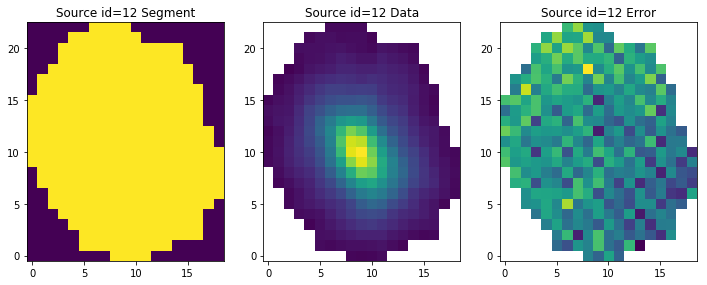

In [45]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(obj.make_cutout(segm2.data))
ax[0].set_title('Source id={} Segment'.format(obj.id))
ax[1].imshow(obj.data_cutout_ma)
ax[1].set_title('Source id={} Data'.format(obj.id))
ax[2].imshow(obj.error_cutout_ma)
ax[2].set_title('Source id={} Error'.format(obj.id))

## Define the approximate isophotal ellipses for each object

Create elliptical apertures for each object using the measured morphological parameters.

In [46]:
from photutils import EllipticalAperture

r = 3.    # approximate isophotal extent
apertures = []
for obj in catalog:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

Now plot the elliptical apertures on the data and the segmentation image.

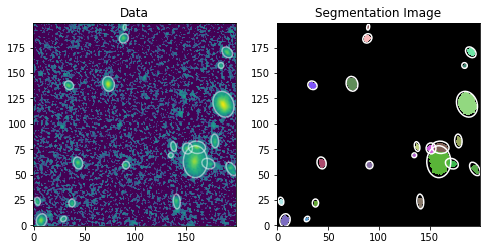

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(segm2, cmap=segm2.cmap())
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(color='white', lw=1.5, alpha=0.5, ax=ax1)
    aperture.plot(color='white', lw=1.5, alpha=1.0, ax=ax2)

_Note that the segmentation image can be reused on other registered data (e.g. multiple filters) to generate a multiband catalog.  One does not need to regenerate it each time -- simply apply it to other bands and/or data._

The segmentation image can also be modified before measuring source photometry/properties, e.g.:

 - remove source segments (artifacts, diffraction spikes, etc.)
 - combine segments
 - mask regions of a segmentation image (e.g. near image borders)

See [modifying segmentation images](https://photutils.readthedocs.io/en/stable/segmentation.html#modifying-a-segmentation-image) for further information.

If desired, a `SExtractor` segmentation image can even be input to Photutils `source_properties()`.

To generate a `SExtractor` segmentation image, set the following in the SExtractor config:
```
CHECKIMAGE_TYPE   SEGMENTATION
CHECKIMAGE_NAME   segmentation.fits
```

Once `segmentation.fits` exists, one could do the following:

`>>> from photutils import SegmentationImage`

`>>> se_segm_data = fits.getdata('segmentation_fits')`

`>>> se_segm = SegmentationImage(se_segm_data)`

`>>> se_cat = source_properties(data, se_segm, error=error, wcs=wcs, labels=labels)`

Note that `data` and `se_segm_data` must have the same shape and be registered.